In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import numpy as np

# Load the cleaned dataset
df = pd.read_csv('keywords_data.csv')

# Configure visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)



Correlation Analysis

In [3]:
# List of cleaned rank columns for each domain
rank_cols = [
    'yatchingpages.com_cleaned_rank', 
    'superyachttimes.com_rank_cleaned',
    'superyachtcontent.com_cleaned_rank', 
    'superyachtserviceguide.com_cleaned_rank',
    'boatinternation.com_cleaned_rank'
]

print("--- Spearman Correlation: Rank vs. Keyword Difficulty ---")
for col in rank_cols:
    # We drop rows where KD is null to ensure a valid calculation
    temp_df = df[[col, 'Keyword Difficulty']].dropna()
    
    coef, p_value = spearmanr(temp_df[col], temp_df['Keyword Difficulty'])
    
    print(f"Domain: {col.split('_')[0]}")
    print(f"  Correlation Coefficient: {coef:.3f}")
    print(f"  P-Value: {p_value:.4f}")
    print("-" * 30)

--- Spearman Correlation: Rank vs. Keyword Difficulty ---
Domain: yatchingpages.com
  Correlation Coefficient: 0.285
  P-Value: 0.0000
------------------------------
Domain: superyachttimes.com
  Correlation Coefficient: -0.059
  P-Value: 0.0000
------------------------------
Domain: superyachtcontent.com
  Correlation Coefficient: -0.037
  P-Value: 0.0011
------------------------------
Domain: superyachtserviceguide.com
  Correlation Coefficient: 0.036
  P-Value: 0.0015
------------------------------
Domain: boatinternation.com
  Correlation Coefficient: -0.106
  P-Value: 0.0000
------------------------------


In [4]:
# Drop rows where CPC or Search Volume are null
market_data = df[['Search Volume', 'CPC']].dropna()

coef, p_value = spearmanr(market_data['Search Volume'], market_data['CPC'])

print(f"--- Spearman Correlation: Search Volume vs. CPC ---")
print(f"Correlation Coefficient: {coef:.3f}")
print(f"P-Value: {p_value:.4f}")

--- Spearman Correlation: Search Volume vs. CPC ---
Correlation Coefficient: 0.017
P-Value: 0.4897


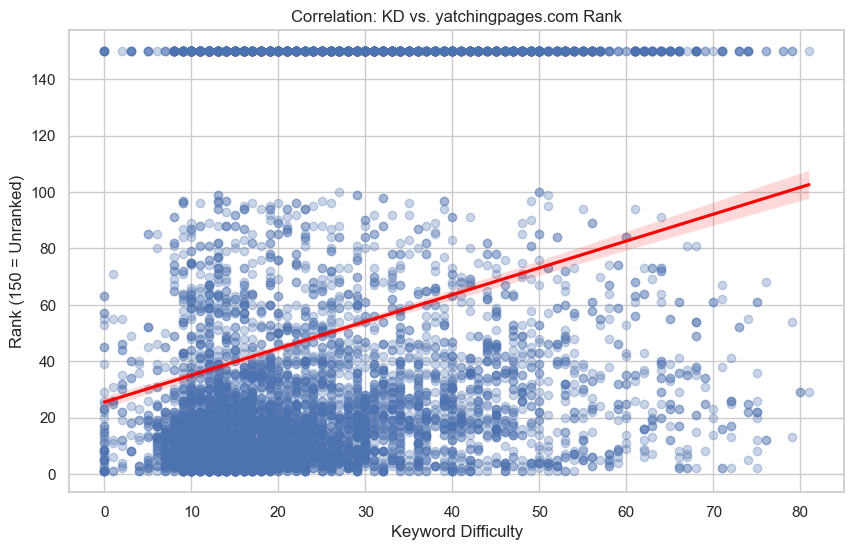

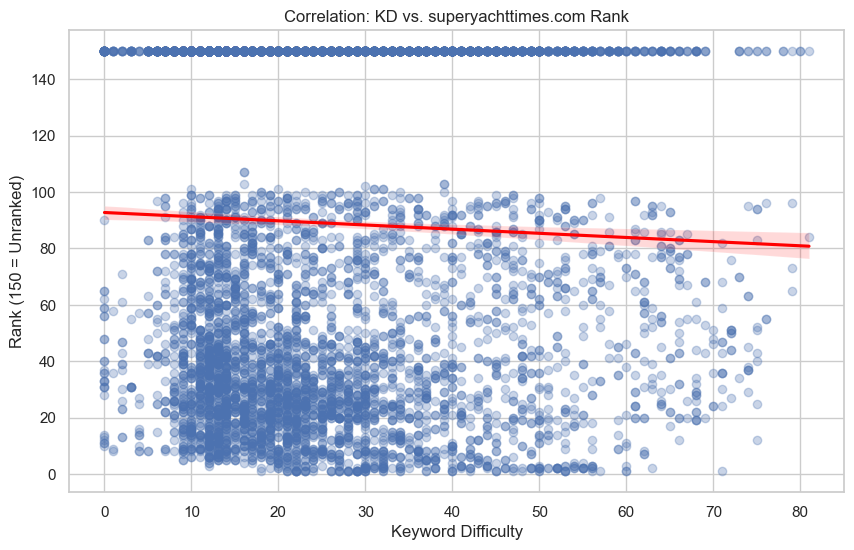

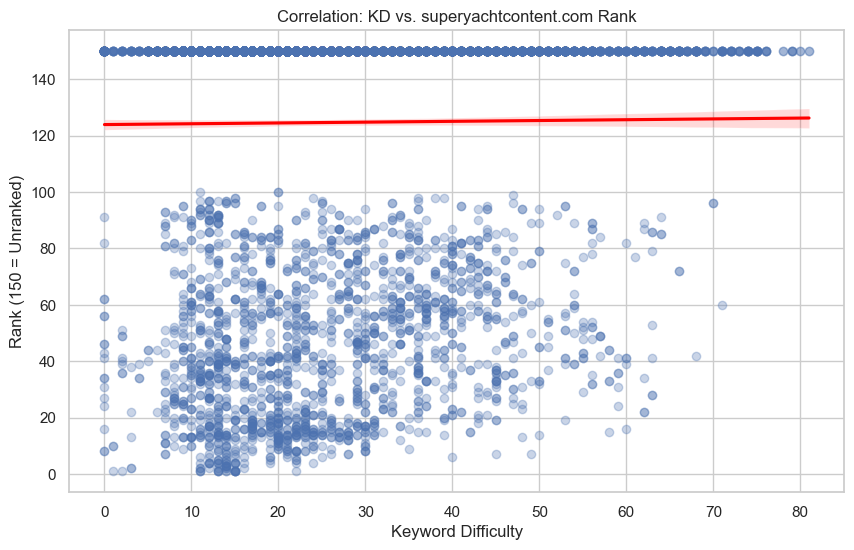

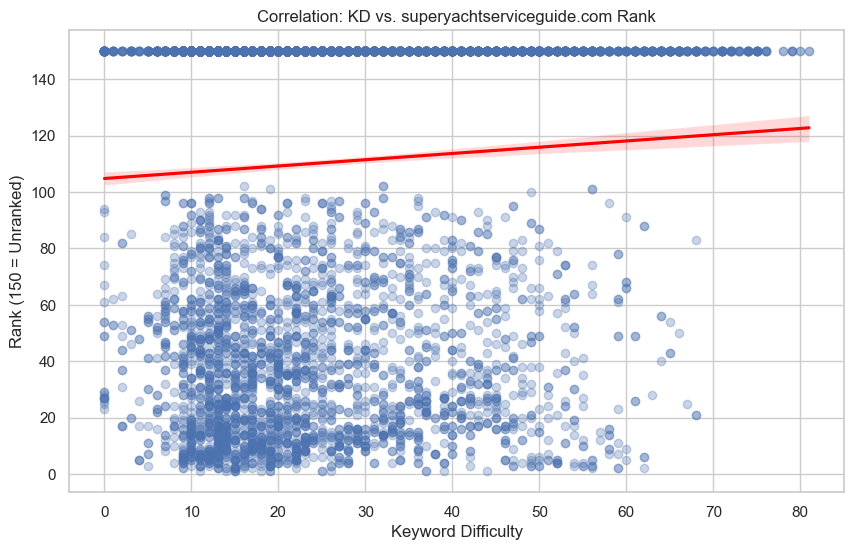

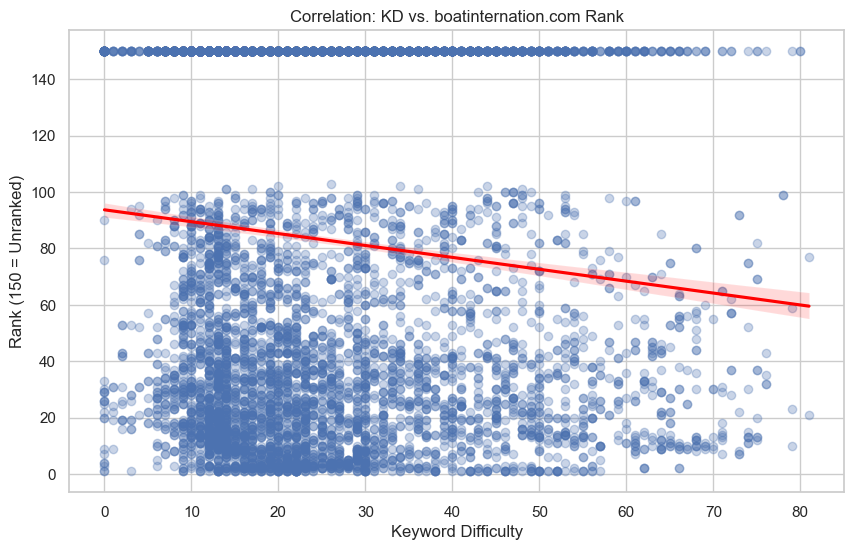

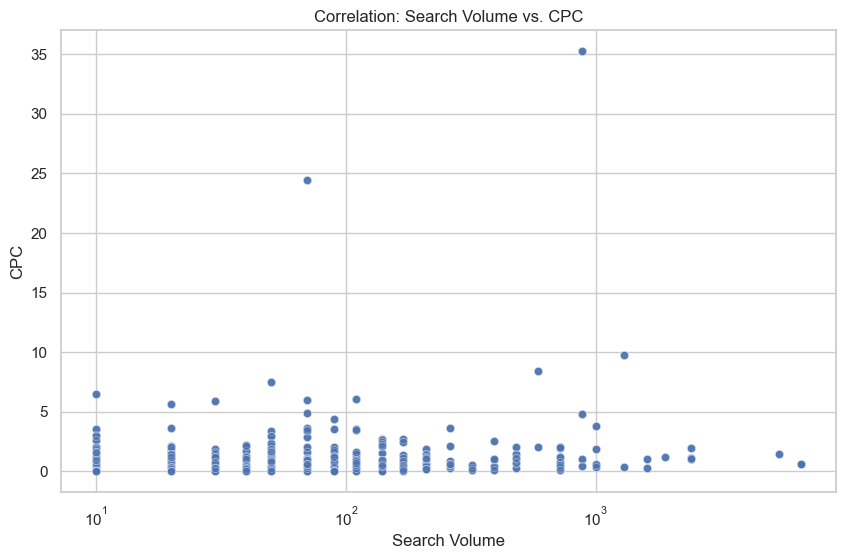

In [31]:
# Plot 1: Keyword Difficulty vs Rank - Separate plots for each domain
for col in rank_cols:
    plt.figure(figsize=(10, 6))
    sns.regplot(data=df, x='Keyword Difficulty', y=col, 
                scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title(f'Correlation: KD vs. {col.split("_")[0]} Rank')
    plt.ylabel('Rank (150 = Unranked)')
    plt.show()

# Plot 2: Search Volume vs CPC - Separate figure
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Search Volume', y='CPC', alpha=0.5)
plt.title('Correlation: Search Volume vs. CPC')
plt.xscale('log')
plt.show()


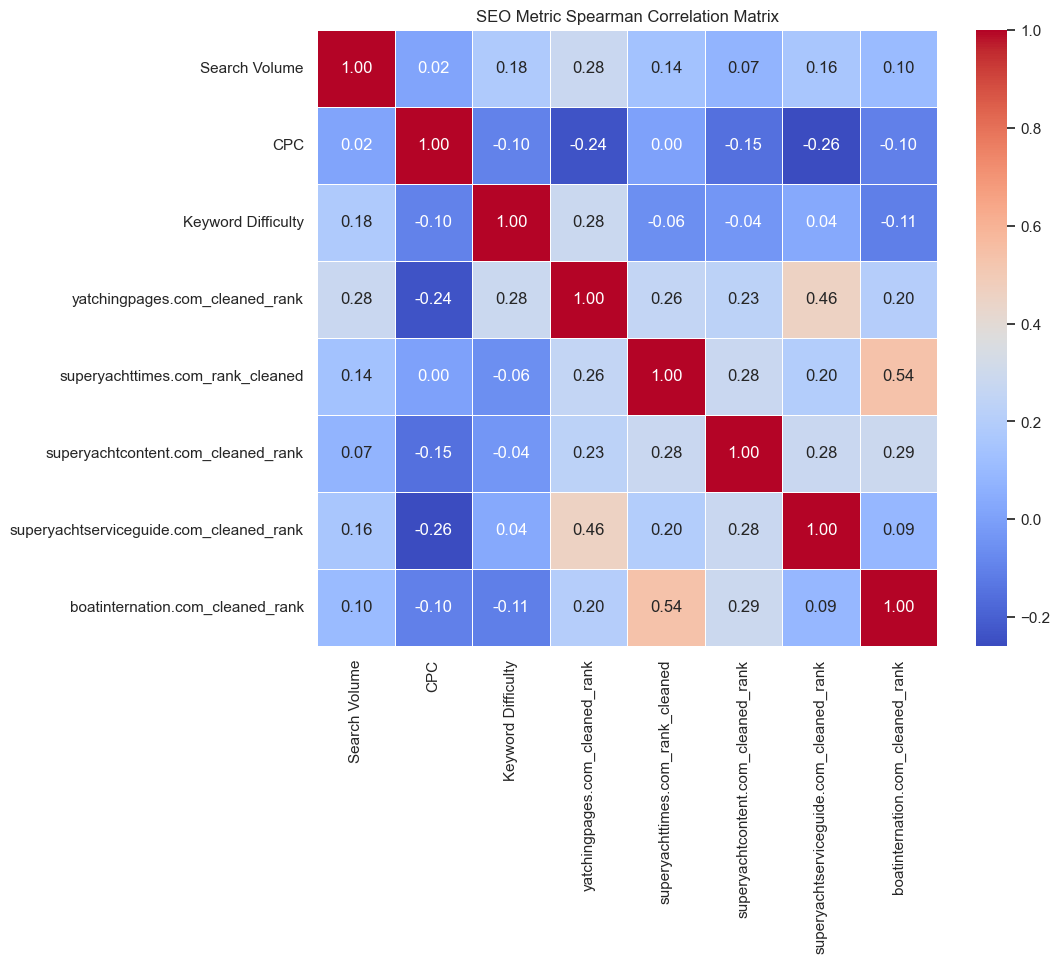

In [6]:
# Select key metrics for the heatmap
heatmap_cols = ['Search Volume', 'CPC', 'Keyword Difficulty'] + rank_cols
corr_matrix = df[heatmap_cols].corr(method='spearman')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('SEO Metric Spearman Correlation Matrix')
plt.show()

Quadrant Analysis

In [32]:
# 1. Handle Nulls for Matrix Analysis
# We fill Volume with 0 and KD with the average if missing to avoid losing data points
df['Search Volume'] = df['Search Volume'].fillna(0)
df['Keyword Difficulty'] = df['Keyword Difficulty'].fillna(df['Keyword Difficulty'].median())
df['CPC'] = df['CPC'].fillna(0)

# 2. Define Thresholds
vol_threshold = df['Search Volume'].median()
kd_threshold = df['Keyword Difficulty'].median()
cpc_threshold = df['CPC'].median()

print(f"Volume Threshold: {vol_threshold}")
print(f"Difficulty Threshold: {kd_threshold}")
print(f"CPC Threshold: {cpc_threshold}")

Volume Threshold: 10.0
Difficulty Threshold: 21.0
CPC Threshold: 0.0


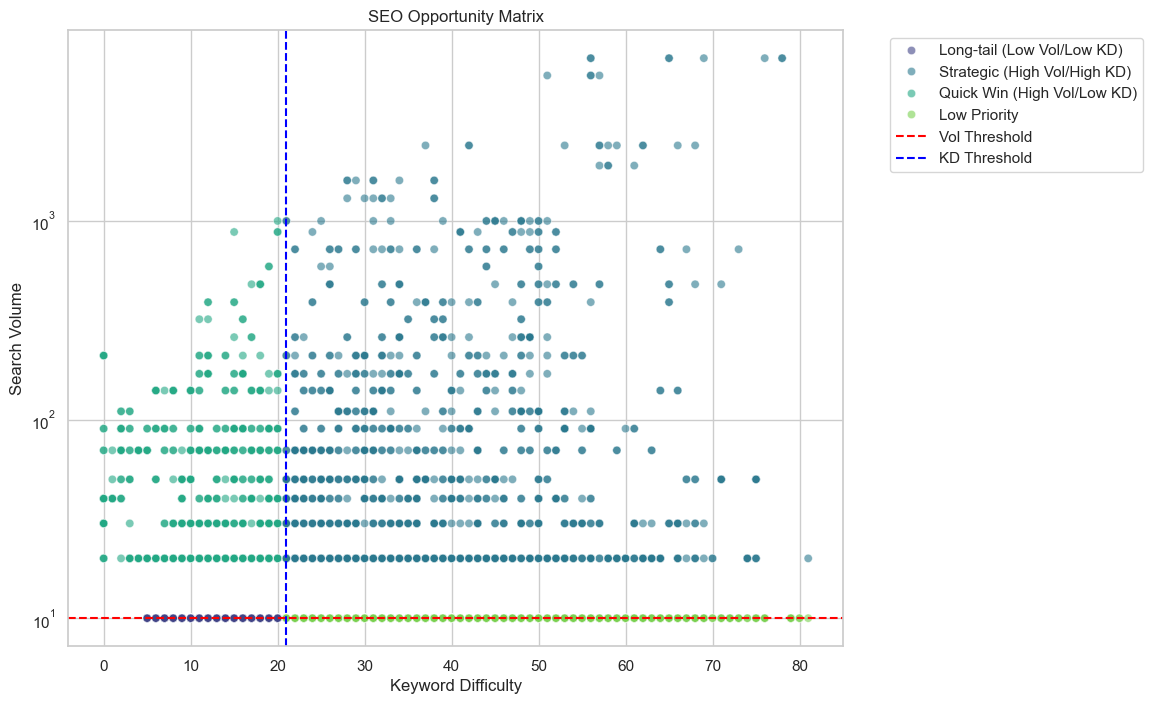

In [9]:
def classify_opportunity(row):
    if row['Search Volume'] > vol_threshold and row['Keyword Difficulty'] < kd_threshold:
        return 'Quick Win (High Vol/Low KD)'
    elif row['Search Volume'] > vol_threshold and row['Keyword Difficulty'] >= kd_threshold:
        return 'Strategic (High Vol/High KD)'
    elif row['Search Volume'] <= vol_threshold and row['Keyword Difficulty'] < kd_threshold:
        return 'Long-tail (Low Vol/Low KD)'
    else:
        return 'Low Priority'

df['Opportunity_Quadrant'] = df.apply(classify_opportunity, axis=1)

# Visualize the Opportunity Matrix
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='Keyword Difficulty', y='Search Volume', 
                hue='Opportunity_Quadrant', palette='viridis', alpha=0.6)

plt.axhline(vol_threshold, color='red', linestyle='--', label='Vol Threshold')
plt.axvline(kd_threshold, color='blue', linestyle='--', label='KD Threshold')
plt.yscale('log') # Log scale helps see clusters better
plt.title('SEO Opportunity Matrix')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [35]:
# Extract the high-priority "On the Cusp" keywords
priority_list = df[df['Value_Quadrant'] == 'On the Cusp (Page 2 - HIGH ROI)'].sort_values(by='CPC', ascending=False)

print(f"Found {len(priority_list)} high-value keywords on the cusp of Page 1.")
# Display top 10
priority_list[['Keyword', 'Search Volume', 'Keyword Difficulty', 'CPC', target_rank_col]].head(10)

Found 208 high-value keywords on the cusp of Page 1.


,Keyword,Search Volume,Keyword Difficulty,CPC,yatchingpages.com_cleaned_rank
6404,yacht concierge,70,2,6.00,12
2462,yacht concierge,70,2,6.00,12
300,yacht concierge,70,5,6.00,19
4929,yacht refit,30,16,5.87,20
770,yacht refit,30,16,5.87,17
4444,yacht chandler,0,22,3.47,16
3129,yacht agent,10,19,3.00,11
7071,yacht agent,10,19,3.00,11
4450,yacht crew insurance,50,18,2.96,18
2475,yacht crew insurance,50,15,2.96,18


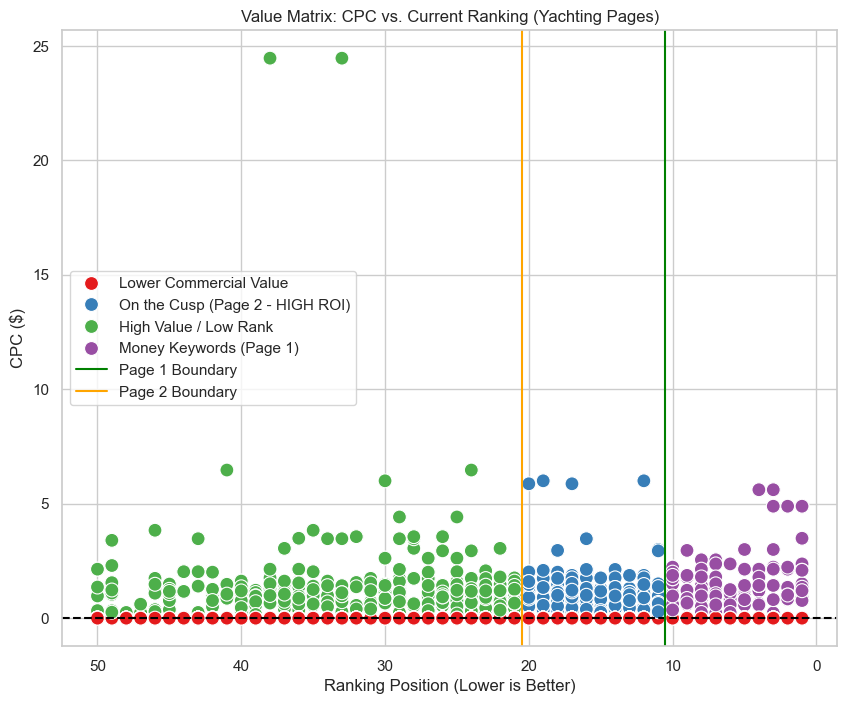

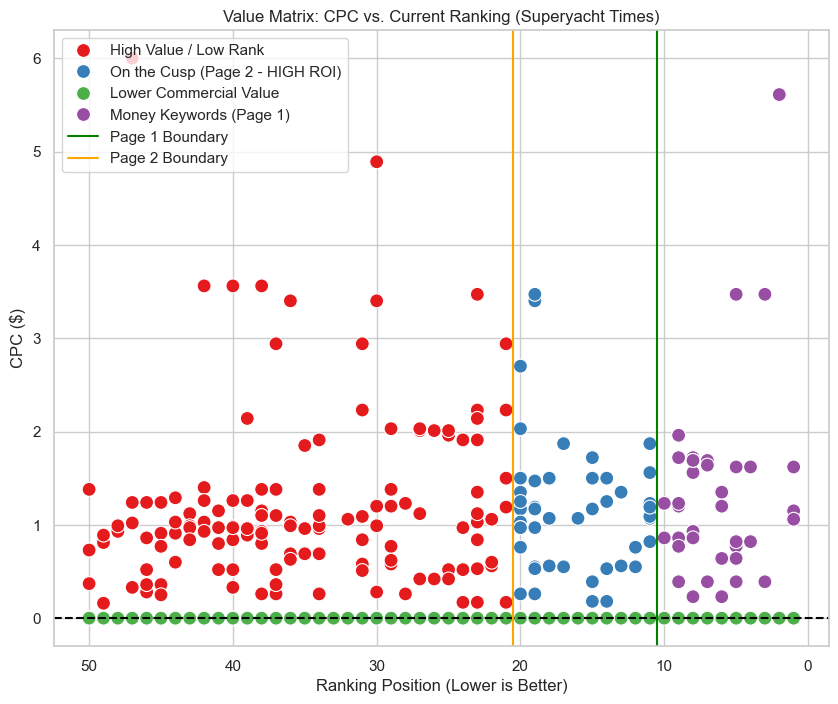

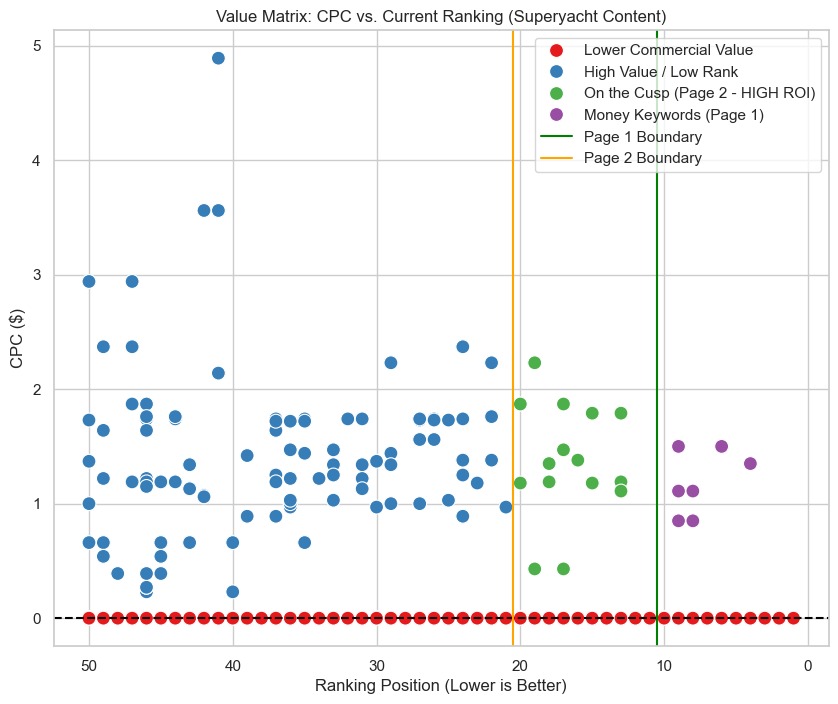

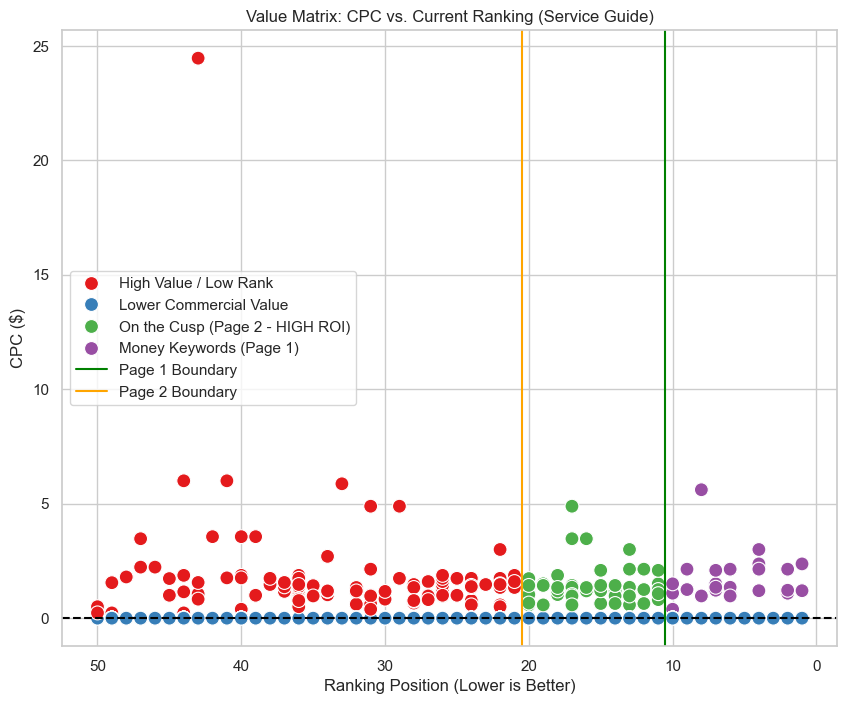

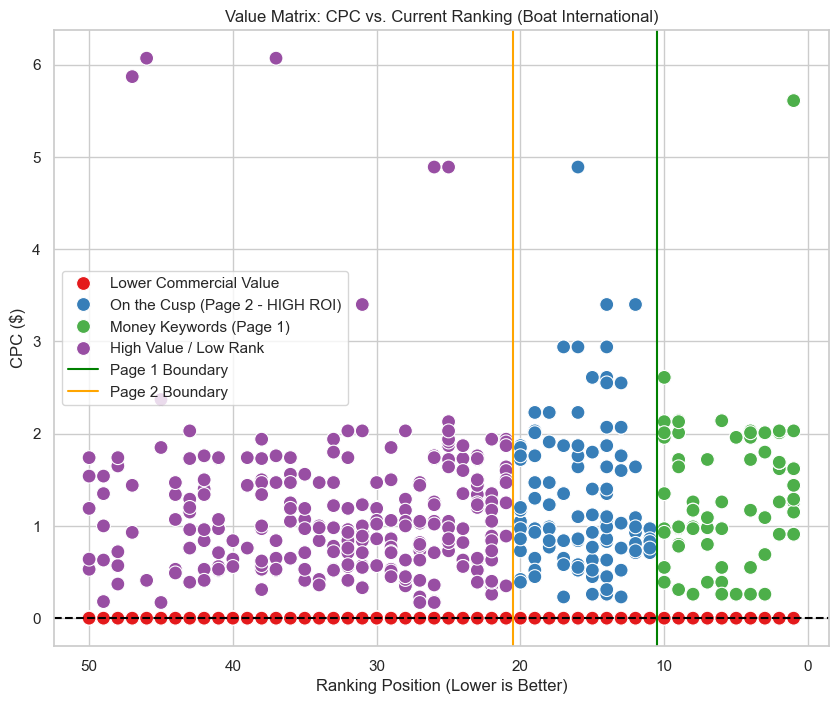

In [34]:
# Value Matrix Analysis for ALL Domains
rank_cols_domains = {
    'Yachting Pages': 'yatchingpages.com_cleaned_rank',
    'Superyacht Times': 'superyachttimes.com_rank_cleaned',
    'Superyacht Content': 'superyachtcontent.com_cleaned_rank',
    'Service Guide': 'superyachtserviceguide.com_cleaned_rank',
    'Boat International': 'boatinternation.com_cleaned_rank'
}

for domain_name, rank_col in rank_cols_domains.items():
    # Create value quadrant classification for this domain
    def classify_value_domain(row, rank_col, threshold):
        rank = row[rank_col]
        cpc = row['CPC']
        
        if cpc > threshold:
            if rank <= 10:
                return 'Money Keywords (Page 1)'
            elif 11 <= rank <= 20:
                return 'On the Cusp (Page 2 - HIGH ROI)'
            else:
                return 'High Value / Low Rank'
        return 'Lower Commercial Value'
    
    df[f'{domain_name}_Value_Quadrant'] = df.apply(lambda row: classify_value_domain(row, rank_col, cpc_threshold), axis=1)
    
    # Visualize the Value Matrix for this domain
    plt.figure(figsize=(10, 8))
    value_plot_df = df[df[rank_col] <= 50]
    
    sns.scatterplot(data=value_plot_df, x=rank_col, y='CPC', 
                    hue=f'{domain_name}_Value_Quadrant', palette='Set1', s=100)
    
    plt.axhline(cpc_threshold, color='black', linestyle='--')
    plt.axvline(10.5, color='green', linestyle='-', label='Page 1 Boundary')
    plt.axvline(20.5, color='orange', linestyle='-', label='Page 2 Boundary')
    
    plt.title(f'Value Matrix: CPC vs. Current Ranking ({domain_name})')
    plt.xlabel('Ranking Position (Lower is Better)')
    plt.ylabel('CPC ($)')
    plt.gca().invert_xaxis()
    plt.legend()
    plt.show()


Gap Analysis

In [37]:
# Define Domain Mapping for easy iteration
domains = {
    'Yachting Pages': {
        'vis': 'yachting-pages.com_visibility',
        'rank': 'yatchingpages.com_cleaned_rank'
    },
    'Superyacht Times': {
        'vis': 'superyachttimes.com_visibility',
        'rank': 'superyachttimes.com_rank_cleaned'
    },
    'Superyacht Content': {
        'vis': 'superyachtcontent.com_visibility',
        'rank': 'superyachtcontent.com_cleaned_rank'
    },
    'Service Guide': {
        'vis': 'superyachtservicesguide.com_visibility',
        'rank': 'superyachtserviceguide.com_cleaned_rank'
    },
    'Boat International': {
        'vis': 'boatinternational.com_visibility',
        'rank': 'boatinternation.com_cleaned_rank'
    }
}

C:\Users\Sameeha\AppData\Local\Temp\ipykernel_10492\4180899295.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sov_df, x='SoV %', y='Domain', palette='magma')


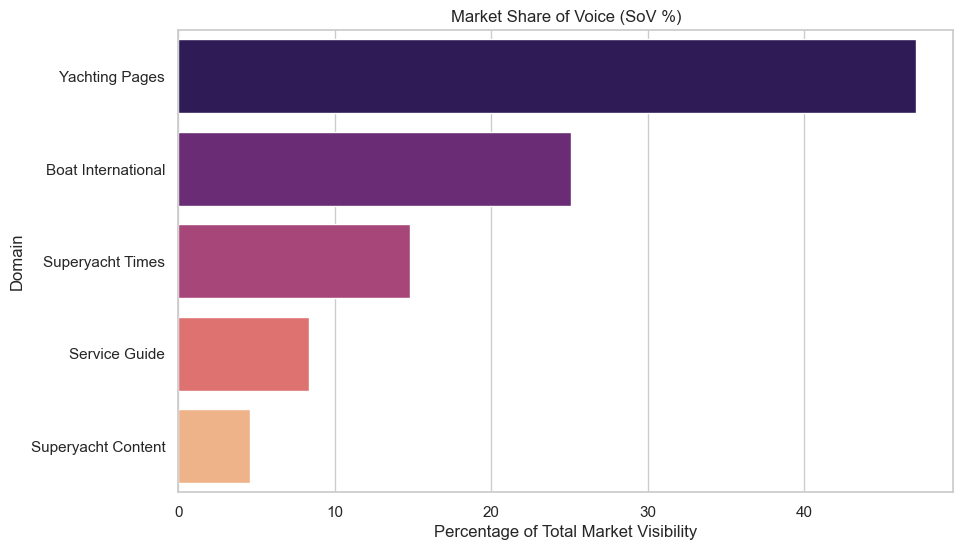

               Domain  Total Visibility      SoV %
0      Yachting Pages         307.45552  47.187544
4  Boat International         163.45017  25.085944
1    Superyacht Times          96.48339  14.808042
3       Service Guide          54.33984   8.339950
2  Superyacht Content          29.83184   4.578520


In [13]:
# Calculate Total Visibility per domain
sov_data = {}
for name, cols in domains.items():
    sov_data[name] = df[cols['vis']].sum()

# Convert to DataFrame
sov_df = pd.DataFrame(list(sov_data.items()), columns=['Domain', 'Total Visibility'])
sov_df['SoV %'] = (sov_df['Total Visibility'] / sov_df['Total Visibility'].sum()) * 100
sov_df = sov_df.sort_values(by='SoV %', ascending=False)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=sov_df, x='SoV %', y='Domain', palette='magma')
plt.title('Market Share of Voice (SoV %)')
plt.xlabel('Percentage of Total Market Visibility')
plt.show()

print(sov_df)

In [38]:
# Define "Ranking" as being in the Top 20
TOP_LIMIT = 20
UNRANKED_LIMIT = 100

# Identify sets of keywords for each domain
ranking_sets = {}
for name, cols in domains.items():
    ranking_sets[name] = set(df[df[cols['rank']] <= TOP_LIMIT]['Keyword'])

# DYNAMIC Gap Analysis: Select target and competitors based on strategy
print("=== DYNAMIC GAP ANALYSIS ===\n")

# Option 1: Identify top competitors by SoV (excluding target)
target = 'Yachting Pages'
sorted_domains = sov_df[sov_df['Domain'] != target].head(2)['Domain'].tolist()
comp1, comp2 = sorted_domains[0], sorted_domains[1]

print(f"Target Domain: {target}")
print(f"Top Competitors by SoV: {comp1} ({sov_df[sov_df['Domain']==comp1]['SoV %'].values[0]:.1f}%), {comp2} ({sov_df[sov_df['Domain']==comp2]['SoV %'].values[0]:.1f}%)\n")

# Calculate gap: keywords where BOTH competitors rank, but target doesn't
gap_keywords = (ranking_sets[comp1] & ranking_sets[comp2]) - ranking_sets[target]

print(f"--- Gap Analysis: {target} vs. Top Competitors ---")
print(f"Keywords where both {comp1} AND {comp2} rank in Top {TOP_LIMIT}, but {target} is missing: {len(gap_keywords)}")

# Export the Gap List
gap_df = df[df['Keyword'].isin(gap_keywords)].sort_values(by='Search Volume', ascending=False)
print("\nTop 15 Gap Opportunities (sorted by Search Volume):\n")
print(gap_df[['Keyword', 'Search Volume', 'Keyword Difficulty', 'CPC']].head(15).to_string())

# BONUS: Show gap analysis for ALL targets vs top 2 competitors
print("\n\n=== GAP ANALYSIS FOR ALL DOMAINS ===\n")
for target_domain in ranking_sets.keys():
    other_domains = [d for d in ranking_sets.keys() if d != target_domain]
    top_competitors = sov_df[sov_df['Domain'].isin(other_domains)].head(2)['Domain'].tolist()
    
    if len(top_competitors) >= 2:
        gap_kw = (ranking_sets[top_competitors[0]] & ranking_sets[top_competitors[1]]) - ranking_sets[target_domain]
        gap_count = len(gap_kw)
        print(f"{target_domain}: {gap_count} gap keywords (vs. {top_competitors[0]} & {top_competitors[1]})")


=== DYNAMIC GAP ANALYSIS ===

Target Domain: Yachting Pages
Top Competitors by SoV: Boat International (25.1%), Superyacht Times (14.8%)

--- Gap Analysis: Yachting Pages vs. Top Competitors ---
Keywords where both Boat International AND Superyacht Times rank in Top 20, but Yachting Pages is missing: 5

Top 15 Gap Opportunities (sorted by Search Volume):

                    Keyword  Search Volume  Keyword Difficulty   CPC
6567           yacht tender            480                  18  1.47
4596           yacht tender            480                  17  1.47
2625           yacht tender            480                  18  1.47
436            yacht tender            480                  18  1.47
2548  yacht interior design            260                  17  2.14
6490  yacht interior design            260                  17  2.14
4522  yacht interior design            260                  23  2.14
423   yacht interior design            260                  15  2.14
2189           yacht 

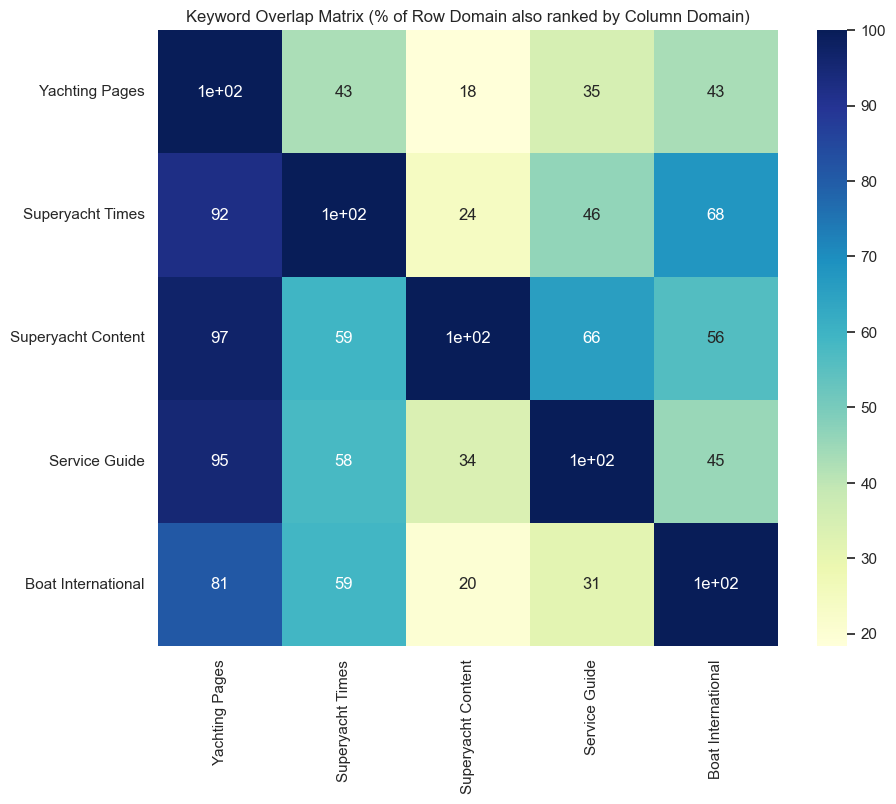

In [39]:
import numpy as np

# Create an empty matrix
matrix_size = len(domains)
overlap_matrix = np.zeros((matrix_size, matrix_size))
domain_names = list(domains.keys())

# Fill the matrix with percentage overlap
for i, d1 in enumerate(domain_names):
    for j, d2 in enumerate(domain_names):
        set1 = ranking_sets[d1]
        set2 = ranking_sets[d2]
        if len(set1) > 0:
            overlap_matrix[i, j] = len(set1 & set2) / len(set1) * 100

# Visualize as Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix, annot=True, xticklabels=domain_names, yticklabels=domain_names, cmap='YlGnBu')
plt.title('Keyword Overlap Matrix (% of Row Domain also ranked by Column Domain)')
plt.show()

Pivot Analysis

In [40]:
# Map intent codes to readable names
intent_map = {
    'i': 'Informational',
    'c': 'Commercial',
    't': 'Transactional',
    'n': 'Navigational'
}
df['Intent_Label'] = df['primary intent'].map(intent_map)

# List of Rank Difference columns to analyze geographic shifts
diff_cols = [
    'yachting-pages.com_rank_difference',
    'superyachttimes.com_rank_difference',
    'superyachtcontent.com_rank_difference',
    'superyachtservicesguide.com_rank_difference',
    'boatinternational.com_rank_difference'
]

--- Intent Segmentation: Difficulty Analysis ---
                    mean  median  count
Intent_Label                           
Informational  23.909091    20.0   6413
Transactional  24.774194    21.0     31
Commercial     27.519525    24.0   1178
Navigational   35.169492    31.5    236


C:\Users\Sameeha\AppData\Local\Temp\ipykernel_10492\1599544734.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Intent_Label', y='Keyword Difficulty', palette='coolwarm')


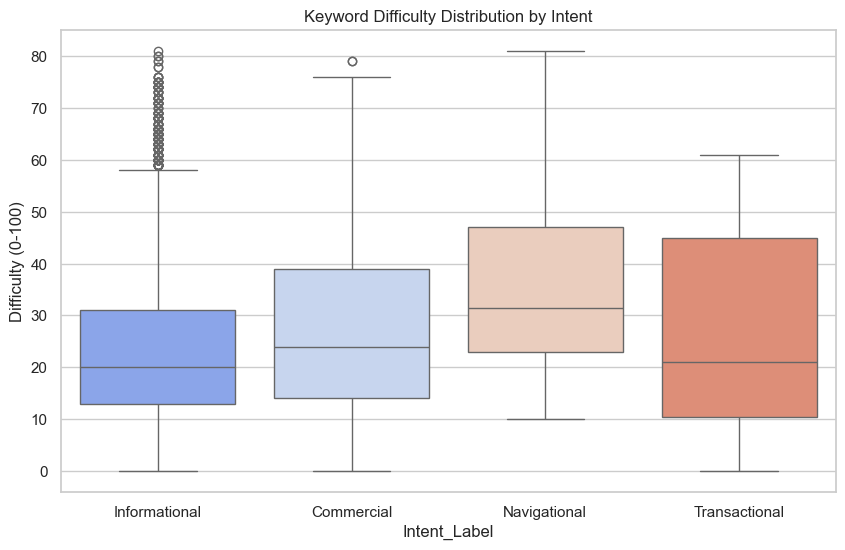

In [41]:
# Group by Intent and calculate mean Keyword Difficulty
intent_difficulty = df.groupby('Intent_Label')['Keyword Difficulty'].agg(['mean', 'median', 'count']).sort_values(by='mean')

print("--- Intent Segmentation: Difficulty Analysis ---")
print(intent_difficulty)

# Visualize the spread of Difficulty across Intents
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Intent_Label', y='Keyword Difficulty', palette='coolwarm')
plt.title('Keyword Difficulty Distribution by Intent')
plt.ylabel('Difficulty (0-100)')
plt.show()

--- Geographic Pivot: Average Rank Change by Country ---
                    Yachting Pages  Superyachttimes  Superyachtcontent  \
Country                                                                  
Dominican Republic        0.063536         2.369403           3.004219   
France                    1.592944        -1.154286           0.598253   
Germany                  -0.918768         1.284895           2.080717   
Greece                    0.548913         2.099825           0.061947   
Spain                    -0.144231         0.422018           1.287611   
Turkey                   -0.329655         0.781753           0.909836   
UAE                       0.220000         0.952468           0.807087   
UK                       -0.377333         1.449541          -0.269841   
USA                       0.026439        -0.682156           1.214815   

                    Superyachtservicesguide  Boatinternational  
Country                                                        

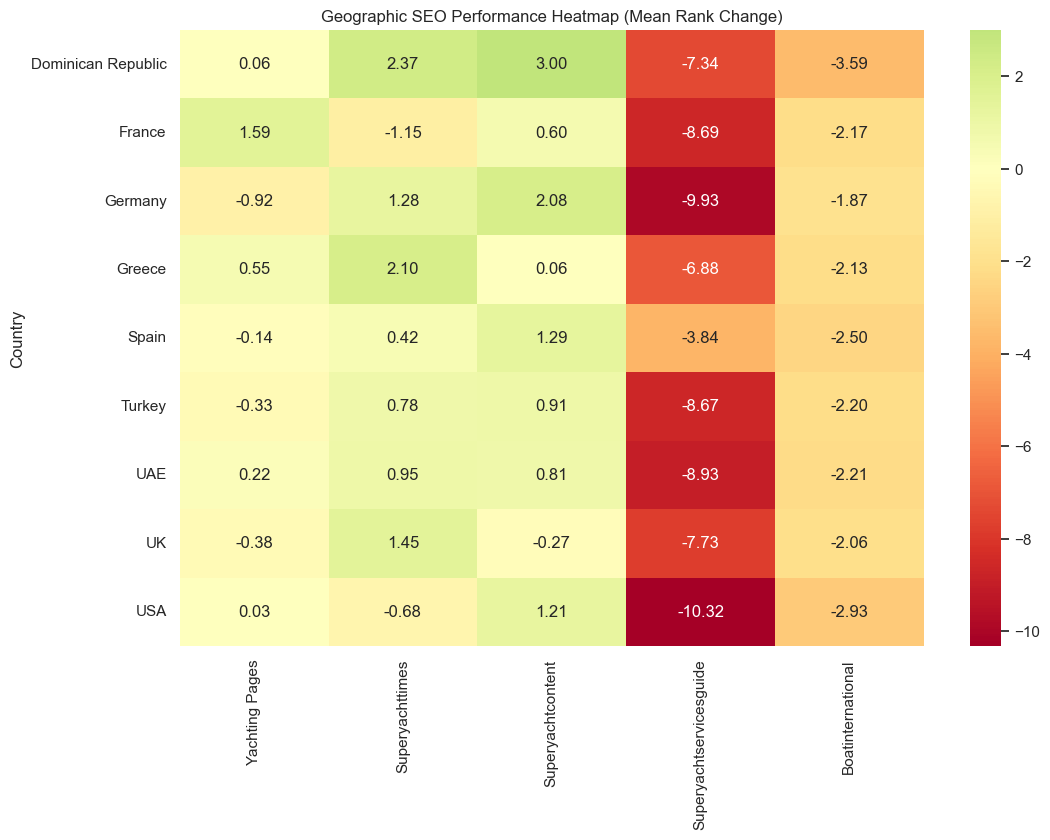

In [42]:
# Create a pivot table: Rows = Country, Columns = Average Rank Difference per Competitor
geo_pivot = df.groupby('Country')[diff_cols].mean()

# Rename columns for the heatmap to be cleaner
geo_pivot.columns = [c.split('.')[0].replace('-', ' ').title() for c in geo_pivot.columns]

print("--- Geographic Pivot: Average Rank Change by Country ---")
print(geo_pivot)

# Visualize with a Heatmap
plt.figure(figsize=(12, 8))
# We use a diverging colormap (RdYlGn) where Green = Improvement, Red = Decline
sns.heatmap(geo_pivot, annot=True, cmap='RdYlGn', center=0, fmt=".2f")
plt.title('Geographic SEO Performance Heatmap (Mean Rank Change)')
plt.show()

In [43]:
# Pivot to see the Average CPC and Difficulty per Country
market_context = df.pivot_table(
    index='Country', 
    values=['CPC', 'Keyword Difficulty', 'Search Volume'], 
    aggfunc='mean'
).sort_values(by='CPC', ascending=False)

print("--- Market Context by Country ---")
print(market_context)

--- Market Context by Country ---
                         CPC  Keyword Difficulty  Search Volume
Country                                                        
USA                 1.152785           21.866438     178.995434
UK                  0.453516           23.825342      76.164384
Spain               0.223470           26.319635      16.392694
France              0.190548           24.644977      21.643836
UAE                 0.168356           22.220320      21.917808
Greece              0.153151           24.617580      21.689498
Germany             0.136530           24.513699      26.575342
Turkey              0.111735           26.278539      58.858447
Dominican Republic  0.009315           28.710046       6.712329


Volatility Analysis

C:\Users\Sameeha\AppData\Local\Temp\ipykernel_10492\787015498.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=growth_df, x='Net Rank Change', y='Domain', palette=colors)


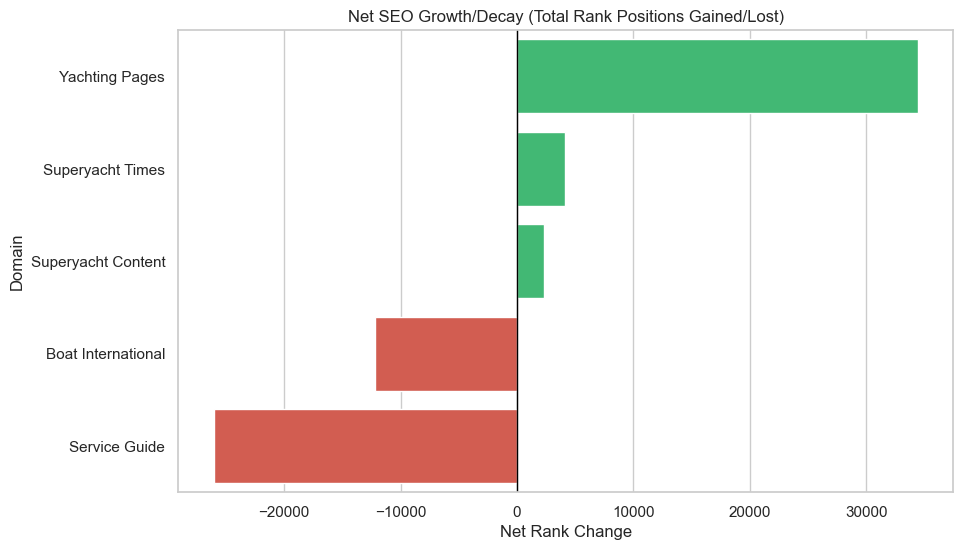

--- SERP Volatility by Intent (Yachting Pages) ---
                Volatility (SD)  Avg Change  Keyword Count
primary intent                                            
n                     21.236557    9.907407            162
c                     16.443522    7.839735            755
i                     14.461857    6.623602           4025
t                     13.876377    5.923077             26


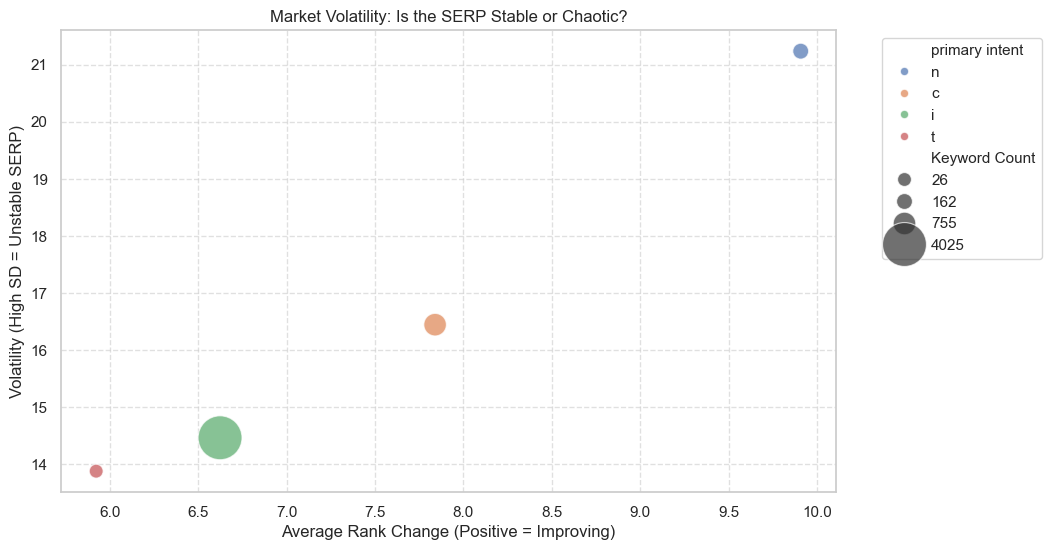

In [44]:
# 1. DEFINE COLUMNS
diff_cols = {
    'Yachting Pages': 'yatching-pages.com_cleaned_rank_difference',
    'Superyacht Times': 'superyachttimes.com_cleaned_rank_difference',
    'Superyacht Content': 'superyachtcontent.com_cleaned_rank_difference',
    'Service Guide': 'superyachtserviceguide.com_cleaned_rank_difference',
    'Boat International': 'boatinternation.com_cleaned_rank_difference'
}

# 2. THE FIX: Force all difference columns to be numeric before starting
for name, col in diff_cols.items():
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. NET GROWTH ANALYSIS (Aggregated Delta)
net_movement = {name: df[col].sum() for name, col in diff_cols.items()}
growth_df = pd.DataFrame(list(net_movement.items()), columns=['Domain', 'Net Rank Change'])
growth_df = growth_df.sort_values(by='Net Rank Change', ascending=False)

# Plotting Growth
plt.figure(figsize=(10, 6))
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in growth_df['Net Rank Change']]
sns.barplot(data=growth_df, x='Net Rank Change', y='Domain', palette=colors)
plt.title('Net SEO Growth/Decay (Total Rank Positions Gained/Lost)')
plt.axvline(0, color='black', lw=1)
plt.show()

# 4. VOLATILITY ANALYSIS (Standard Deviation by Intent)
target_diff = diff_cols['Yachting Pages']


volatility_analysis = df.groupby('primary intent')[target_diff].agg(['std', 'mean', 'count'])
volatility_analysis.columns = ['Volatility (SD)', 'Avg Change', 'Keyword Count']

# Filter for groups with more than 5 keywords to avoid "noise"
volatility_analysis = volatility_analysis[volatility_analysis['Keyword Count'] > 5]
volatility_analysis = volatility_analysis.sort_values(by='Volatility (SD)', ascending=False)

print("--- SERP Volatility by Intent (Yachting Pages) ---")
print(volatility_analysis)

# 5. VOLATILITY VISUALIZATION
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=volatility_analysis, 
    x='Avg Change', 
    y='Volatility (SD)', 
    size='Keyword Count', 
    hue=volatility_analysis.index, 
    sizes=(100, 1000),
    alpha=0.7
)
plt.title('Market Volatility: Is the SERP Stable or Chaotic?')
plt.xlabel('Average Rank Change (Positive = Improving)')
plt.ylabel('Volatility (High SD = Unstable SERP)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Timeseries Analysis

In [45]:
# 1. Convert Date to Datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# 2. Define the target domain's rank and landing page columns
rank_col = 'yatchingpages.com_cleaned_rank'
url_col = 'yachting-pages.com_landing'

# Sort by date to ensure the timeline is correct
df = df.sort_values(by='Date')

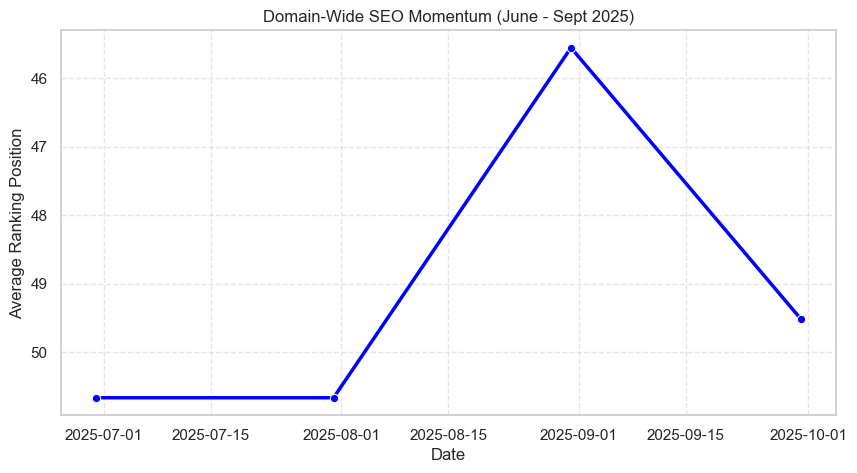

In [46]:
# Aggregate average rank by month
monthly_trend = df.groupby('Date')[rank_col].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_trend, x='Date', y=rank_col, marker='o', color='blue', linewidth=2.5)

# Invert Y-Axis because Rank 1 is better than Rank 50
plt.gca().invert_yaxis()
plt.title('Domain-Wide SEO Momentum (June - Sept 2025)')
plt.ylabel('Average Ranking Position')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [23]:
# Pivot data to see the rank of each Landing Page over time
# We aggregate by URL (Mean rank if multiple keywords point to one URL)
path_decay = df.pivot_table(index=url_col, columns='Date', values=rank_col, aggfunc='mean')

# Filter for pages that exist in both the first and last month
first_month = path_decay.columns.min()
last_month = path_decay.columns.max()
decay_df = path_decay[[first_month, last_month]].dropna()

# Calculate the "Decay Score" (Change in rank)
decay_df['Decay_Score'] = decay_df[last_month] - decay_df[first_month]

# Sort by the worst decay (Largest increase in rank number)
top_decaying_pages = decay_df.sort_values(by='Decay_Score', ascending=False).head(10)

print("--- Top 10 Decaying Landing Pages (Losing Rankings) ---")
print(top_decaying_pages)

--- Top 10 Decaying Landing Pages (Losing Rankings) ---
Date                                                2025-06-30 00:00:00  \
yachting-pages.com_landing                                                
https://www.yachting-pages.com/articles/the-bes...              4.00000   
https://www.yachting-pages.com/articles/an-intr...             33.00000   
https://www.yachting-pages.com/listing/cosmo-cr...             36.00000   
https://www.yachting-pages.com/articles/top-lux...             57.20000   
https://www.yachting-pages.com/listing/metal-wo...             34.00000   
https://www.yachting-pages.com/listing/yacht-ma...             30.47619   
https://www.yachting-pages.com/articles/yacht-l...             11.40000   
https://www.yachting-pages.com/listing/yacht-bo...             11.00000   
https://www.yachting-pages.com/listing/elite-su...             31.00000   
https://www.yachting-pages.com/listing/yacht-bo...              7.60000   

Date                                       

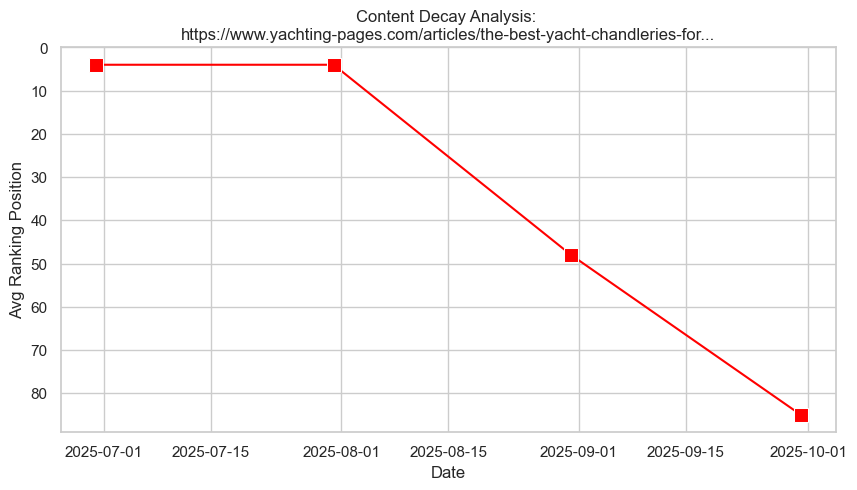

In [47]:
# Pick the top decaying URL
problem_url = top_decaying_pages.index[0]

# Filter main DF for this URL
url_trend = df[df[url_col] == problem_url].groupby('Date')[rank_col].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=url_trend, x='Date', y=rank_col, marker='s', color='red', markersize=10)
plt.gca().invert_yaxis()
plt.title(f'Content Decay Analysis: \n{problem_url[:70]}...')
plt.ylabel('Avg Ranking Position')
plt.show()